In [1]:
from __future__ import division

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

* log base 2, so that jsdivergence behaves 0 to 1

* h(X) = - sum over i (P(Xi) * log2(P(Xi))
* P(X) is probability mass function of X

* h(x) = P from histogramm of distribution of x
* h(y) = P from histogramm of distribution of y
* h(x,y) = P histogramm of combined distribution
* #bins << # datapoints
* all normalized, i.e. divide # datapoints per bin by all datapoints

* jsdivergence = h(x,y) - .5*[h(x)+h(y)]   (.5 is the weight, if differential weighting adapt accordingly)

* jsdistance = sqrt(jsdivergence)

In [4]:
t1_avg = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_rh_mean_3_7.npy')
cluster = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10_kmeans_5.npy')

In [9]:
data_a = t1_avg[np.where(cluster==4)]
data_b = t1_avg[np.where(cluster==5)]

print data_a.shape
print data_b.shape

(9390,)
(10827,)


### Derive probability mass function

In [389]:
def prob_mass_function(data, bins='auto', range_min=None, range_max=None):
    
    data = data.flatten()
    
    if range_min is None:
        range_min = np.nanmin(data)
    if range_max is None:
        range_max = np.nanmax(data)
        
    if bins == 'auto':
        bins = data.shape[0]/100
        
    p_mass, x_values = np.histogram(data, bins=bins, range=(range_min, range_max))
    p_mass = p_mass / data.shape[0]
    x_values = x_values[:-1] + (x_values[1] - x_values[0])/2
    
    return p_mass, x_values

In [390]:
data_shapes = [data_a.shape[0], data_b.shape[0], np.concatenate((data_a, data_b)).shape[0]]
bins = np.round(data_shapes[np.argmin(data_shapes)]/100)

a_p_mass, a_x_values = prob_mass_function(data_a, bins, range_min=1500, range_max=2500)
b_p_mass, b_x_values = prob_mass_function(data_b,  bins, range_min=1500, range_max=2500)
ab_p_mass, ab_x_values = prob_mass_function(np.concatenate((data_a, data_b)), bins, range_min=1500, range_max=2500)

In [391]:
print a_x_values.shape
print b_x_values.shape
print ab_x_values.shape

(94,)
(94,)
(94,)


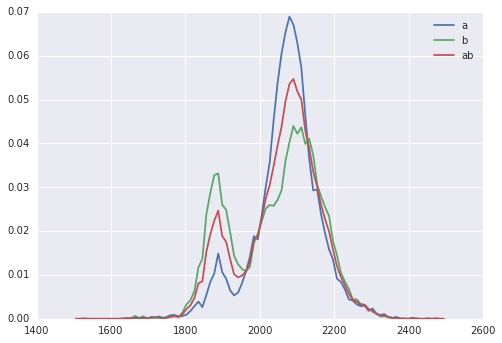

In [392]:
plt.plot(a_x_values,a_p_mass, label='a')
plt.plot(b_x_values,b_p_mass, label='b')
plt.plot(ab_x_values,ab_p_mass, label='ab')
plt.legend()

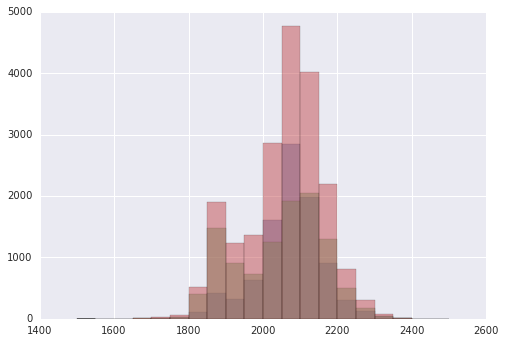

In [393]:
plt.hist(data_a, bins=20, range=(1500, 2500), alpha=0.5);
plt.hist(data_b, bins=20, range=(1500, 2500), alpha=0.5);
plt.hist(data_ab, bins=20, range=(1500, 2500), alpha=0.5);

### Derive jensen shannon divergence / distance

In [451]:
def jensenshannon(data, range_min=None, range_max=None, base=2, weights=None):
    
    if range_min is None:
        data_mins = [np.nanmin(m) for m in data]
        range_min = data_mins[np.argmin(data_mins)]
    
    if range_max is None:
        data_maxs = [np.nanmax(n) for n in data]
        range_max = data_maxs[np.argmax(data_maxs)]
    
    data_shapes = [k.shape[0] for k in data]
    bins = int(np.round(data_shapes[np.argmin(data_shapes)]/100))
    p_mass = np.zeros((len(data), bins))
    
    combined_data = []
    for i in range(len(data)):
        p_mass[i], _ = prob_mass_function(data[i], bins, range_min, range_max)
        combined_data += list(data[i])
        
    p_mass_combined, _ = prob_mass_function(np.asarray(combined_data), bins, range_min, range_max)
    
    shannon_entropy = [sp.stats.entropy(p_mass[j], base=base) for j in range(p_mass.shape[0])]
    shared_shannon_entropy = sp.stats.entropy(p_mass_combined, base=base)
    
    if weights is None:
        weights = 1/len(data)
        
    shannon_entropy = np.asarray(shannon_entropy) * np.asarray(weights)
    
    jsdivergence = shared_shannon_entropy - np.sum(shannon_entropy)
    
    jsdistance = np.sqrt(jsdivergence)
    
    return jsdivergence, jsdistance

In [470]:
fake_1 = np.random.normal(0, 1, size=(1000,))
fake_2 = np.random.normal(1, 1, size=(1000,))
fake_3 = np.random.normal(5, 2, size=(1000,))

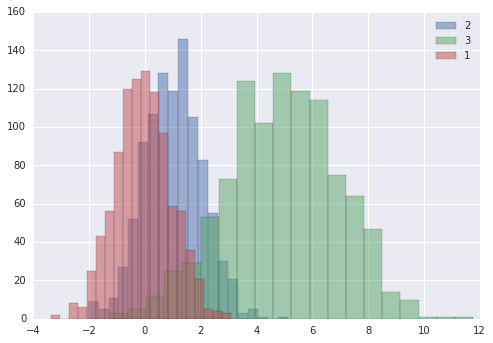

In [471]:
import seaborn as sns
plt.hist(fake_2, bins=20, label='2', alpha=0.5);
plt.hist(fake_3, bins=20, label='3', alpha=0.5);
plt.hist(fake_1, bins=20, label='1', alpha=0.5);
plt.legend()

In [472]:
jsdiv, jsdist = jensenshannon([fake_1, fake_2])
print '1 vs 2', jsdiv, jsdist

1 vs 2 0.174034818639 0.417174805854


In [473]:
jsdiv, jsdist = jensenshannon([fake_1, fake_3])
print '1 vs 3', jsdiv, jsdist

1 vs 3 0.777936721043 0.882007211446


In [474]:
jsdiv, jsdist = jensenshannon([fake_2, fake_3])
print '2 vs 3', jsdiv, jsdist

2 vs 3 0.625800882176 0.791075775243


In [475]:
jsdiv, jsdist = jensenshannon([fake_1, fake_2, fake_3])
print '1,2,3', jsdiv, jsdist

1,2,3 0.744586380228 0.862894188315


In [478]:
jsdiv, jsdist = jensenshannon([fake_1, fake_2], range_min=-4, range_max=12)
print '1 vs 2 on whole range', jsdiv, jsdist

1 vs 2 on whole range 0.153442211419 0.391717004251
